# Classical Segmentation Pipeline

This notebook demonstrates classical segmentation methods (Otsu, Watershed, K-means, and mathematical morphology) on preprocessed MRI images.

- **Single example**: step-by-step with visualization
- **Batch processing**: apply to all images in a folder


In [2]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.morphology import remove_small_objects, binary_opening, binary_closing, disk
from sklearn.cluster import KMeans
from scipy import ndimage as ndi
from pathlib import Path


## 1. Single Example: Step-by-step Segmentation


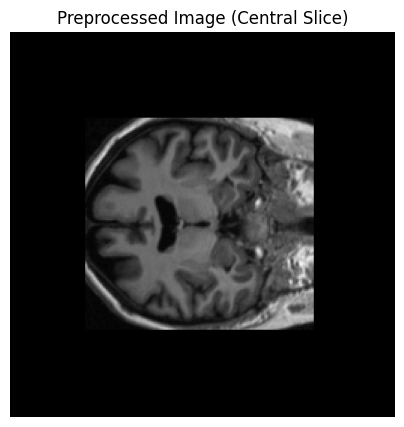

In [3]:
# Choose a preprocessed image (e.g., Z-score normalized)
img_path = Path('../data/preprocessed/IBSR_10_zscore.nii.gz')
img = nib.load(str(img_path))
data = img.get_fdata()

# Use a central slice for 2D visualization
slice_idx = data.shape[2] // 2
slice_img = data[:, :, slice_idx]
plt.figure(figsize=(5,5))
plt.imshow(slice_img, cmap='gray')
plt.title('Preprocessed Image (Central Slice)')
plt.axis('off')
plt.show()

### Otsu Thresholding


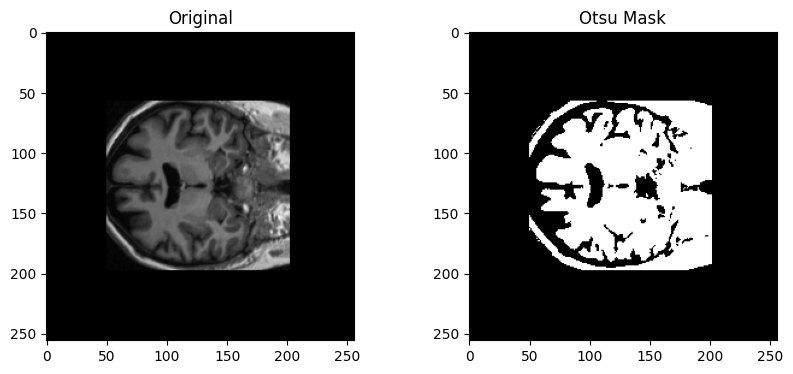

In [4]:
otsu_thresh = threshold_otsu(slice_img)
otsu_mask = slice_img > otsu_thresh
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(slice_img, cmap='gray'); plt.title('Original')
plt.subplot(1,2,2); plt.imshow(otsu_mask, cmap='gray'); plt.title('Otsu Mask')
plt.show()

### Watershed Segmentation


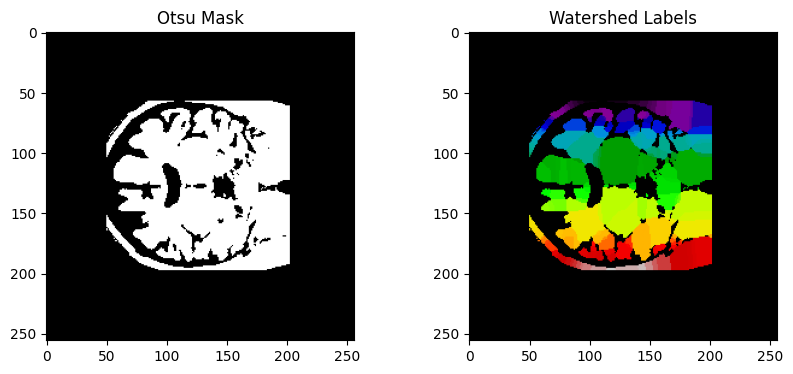

In [6]:
# Compute the distance map
distance = ndi.distance_transform_edt(otsu_mask)
# Find local maxima (returns coordinates)
footprint = np.ones([3] * distance.ndim)
local_maxi = peak_local_max(distance, labels=otsu_mask, footprint=footprint, exclude_border=False)
local_maxi_mask = np.zeros_like(distance, dtype=bool)
local_maxi_mask[tuple(local_maxi.T)] = True
markers = ndi.label(local_maxi_mask)[0]
labels_ws = watershed(-distance, markers, mask=otsu_mask)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(otsu_mask, cmap='gray'); plt.title('Otsu Mask')
plt.subplot(1,2,2); plt.imshow(labels_ws, cmap='nipy_spectral'); plt.title('Watershed Labels')
plt.show()

### K-means Clustering (2 classes)


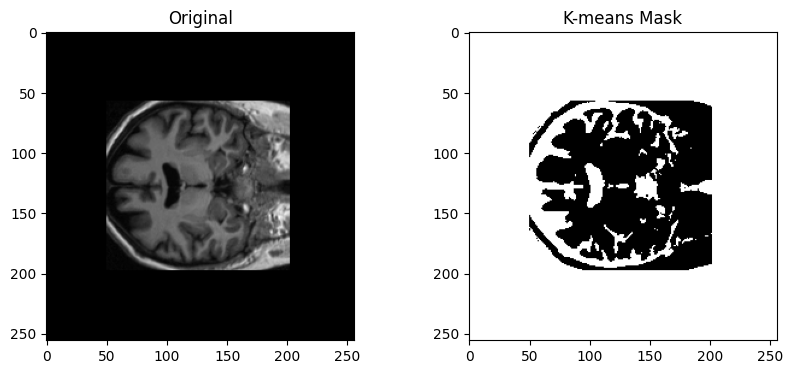

In [7]:
X = slice_img.reshape(-1, 1)
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
kmeans_mask = kmeans.labels_.reshape(slice_img.shape)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(slice_img, cmap='gray'); plt.title('Original')
plt.subplot(1,2,2); plt.imshow(kmeans_mask, cmap='gray'); plt.title('K-means Mask')
plt.show()

### Mathematical Morphology (Refinement)


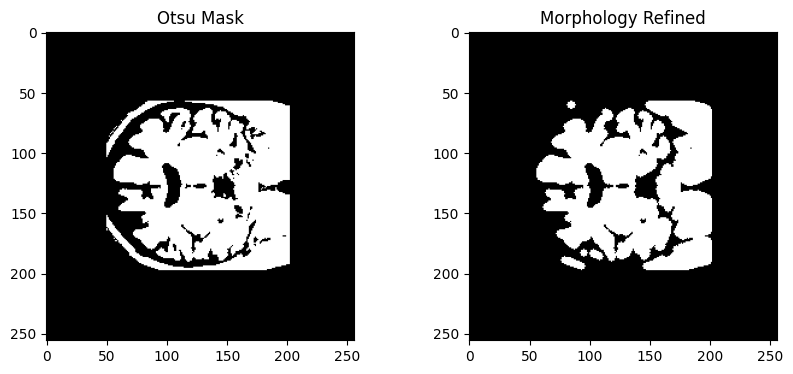

In [9]:
from skimage.morphology import disk, ball
morph_mask = remove_small_objects(otsu_mask, min_size=100)

if morph_mask.ndim == 2:
    selem = disk(3)
else:
    selem = ball(3)

# Example: remove small objects and apply opening
morph_mask = binary_opening(morph_mask, selem)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(otsu_mask, cmap='gray'); plt.title('Otsu Mask')
plt.subplot(1,2,2); plt.imshow(morph_mask, cmap='gray'); plt.title('Morphology Refined')
plt.show()

## 2. Batch Processing: Apply to All Preprocessed Images


In [ ]:
input_dir = Path('/home/orion23/Documents/repos/neurocut-tms-navigation-segmentation/data/preprocessed')
output_dir = Path('/home/orion23/Documents/repos/neurocut-tms-navigation-segmentation/data/classical_segmented')
output_dir.mkdir(exist_ok=True)

for img_path in input_dir.glob('*_zscore.nii.gz'):
    img = nib.load(str(img_path))
    data = img.get_fdata()
    # Otsu (3D)
    otsu_thresh = threshold_otsu(data)
    otsu_mask = data > otsu_thresh
    nib.save(nib.Nifti1Image(otsu_mask.astype(np.uint8), img.affine), output_dir / f'{img_path.stem}_otsu.nii.gz')
    # K-means (3D, 2 classes)
    X = data.reshape(-1, 1)
    kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
    kmeans_mask = kmeans.labels_.reshape(data.shape)
    nib.save(nib.Nifti1Image(kmeans_mask.astype(np.uint8), img.affine), output_dir / f'{img_path.stem}_kmeans.nii.gz')
    # Morphology (remove small objects)
    morph_mask = remove_small_objects(otsu_mask, min_size=100)
    nib.save(nib.Nifti1Image(morph_mask.astype(np.uint8), img.affine), output_dir / f'{img_path.stem}_morph.nii.gz')
    print(f'Segmentation done for {img_path.name}')
